# Heisman Candidate Analysis

## Rebecca Kahler

The Hesiman started in 1935 and was meant to be awareded to the most valuable player in collge football. Some might say that the most valuable player and the best player are two different things. For the purpose of this project, we will assume that the Hesiman is meant to be awarded to the best player in cfb. We would like to analyze the veracity of this claim. Given the past decade, it is not obvious that the Heisman is given to the best player in CFB, but rather the quarterback on the best team. We would like to know if a team's popularity affects Hesiman. 


To do our analysis, we will be scraping various pages from  https://www.sports-reference.com/. This is where we will get player the player statistics which will we will use to see if they are truly outliers at their position or not. We will also be scraping the AP poll from https://www.wikipedia.org. To determine 'popularity', we will use the AP polls to find the proportion of polls the teams were ranked in a given year, then calculate a rolling average. We will also consider win percentage in our final analysis.

Finally, to avoid overfitting of our model, we will Heisman finalists to be our target column. 

github repository: https://github.com/rjkahler/rjkahler.github.io

Data Sources so far: https://www.heisman.com/heisman-winners/, https://www.sports-reference.com/

Project goal: To determine if the Heisman winner is the objectively best football player in the nation, and is not some sort of popularity contest. Data will be scraped from sources listed above. In the cell below, I am storing some data sources that I am thinking about using.

In [1]:
#Link we want to be able to scrape depending on the info we want. Hopefully we can do the same function for each
#page. I think it should be possible.
#https://www.sports-reference.com/cfb/years/2023-team-defense.html
#https://www.sports-reference.com/cfb/years/2023-special-teams.html
#https://www.sports-reference.com/cfb/years/2023-ratings.html
#https://www.sports-reference.com/cfb/years/2023-polls.html

#this on would be different and might be uncessecary
#https://www.sports-reference.com/cfb/years/2022-leaders.html

# Step 1: Scraping our data, cleaning, and some EDA.

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import math as m
import numpy as np
import  matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.stats import zscore
from datetime import timedelta
from labellines import labelLines
import re

Our first order of business is to get all of the finalist information. We can do so by scraping https://www.sports-reference.com for the ballot data. Instead of webcrawling, I build the urls where I can find the ballot information on sports reference since they are pretty easy to make. 

In [4]:
#Building the urls.
urls = ['https://www.sports-reference.com/cfb/awards/heisman-'+ f'{year}'+'.html' for year in range(1935,2024)]

#https://www.sports-reference.com only allows 20 requests per minute, so I've implemented a timer to get around
#this (which is why this guy is in a loop instead of an iterated list).
heis_soups = []
for url in urls:
    heis_soups.append(BeautifulSoup(requests.get(url).text, 'html.parser'))
    time.sleep(5)

Now that we are all of the information in soup objects, we know have to transform it into something that makes sense. I have built two different functions for the purpose of scraping https://www.sports-reference.com. The only difference between the two functions is that one normalizes (z-scores) columns and one does not. The one below, as the name implies, does not normalize any columns. The function works by taking in a soup, and then proceeds as follows:

1) Selects the table where the data can be found
2) Extracts all rows of the table
3) Uses the first row information to get the column names
4) Extracts the text from under the html tag
5) Filters the data down into the data that we want (in some cases, the tables have extraneous rows that we don't want
6) Builds the dataframe and uses the heading of the webpage to get the year that this data was from.

In [5]:
def not_norm_df_build(soup):
    table = soup.find_all('tbody')[0]
    rows = table.find_all('tr')
    col_names = [thing.get('data-stat') for thing in rows[0].find_all('td')]
    all_row_data = [[thing.text for thing in row.find_all('td')] for row in rows]
    row_data = [list_ for list_ in all_row_data if len(list_) == len(col_names)]

    df = pd.DataFrame(columns = col_names, data = row_data)
    #Since this functin is called at the year level, we need to have a column indicating the year so we can keep
    #track of where the data is coming from
    web_head = soup.find_all('h1')[0].text.split()
    df['year'] = pd.to_numeric(web_head[0].strip())
    return df

Now to actually build the dataframe. We will call our function at a year level. The function returns a dataframe, so we use concat to stack the dataframes on top of eachother, and then reset the index. Now since the tables on sportsreference have the finalists in order of finish, reseting the index of each dataframe dictates the place a finalist received minus 1 since indexing in python starts at 0. This is why we rename the old index colunb to 'finish' and then add one.

In [6]:
ballot_df = pd.concat([not_norm_df_build(soup) for soup in heis_soups]).reset_index()
ballot_df.rename(columns = {'index': 'finish'}, inplace = True)
ballot_df['finish'] = ballot_df['finish'] + 1
ballot_df.tail(10)

,finish,player,school_name,class,pos,votes_first,votes_second,votes_third,points_won,summary,year
845,1,Jayden Daniels,LSU,SR,QB,503,217,86,2029,"236 Cmp, 327 Att, 3812 Yds, 40 TD, 4 Int",2023
846,2,Michael Penix Jr.,Washington,SR,QB,292,341,143,1701,"307 Cmp, 466 Att, 4218 Yds, 33 TD, 9 Int",2023
847,3,Bo Nix,Oregon,SR,QB,51,205,322,885,"336 Cmp, 435 Att, 4145 Yds, 40 TD, 3 Int",2023
848,4,Marvin Harrison Jr.,Ohio State,JR,WR,20,78,136,352,"67 Rec, 1211 Yds, 18.1 Avg, 14 TD",2023
849,5,Jordan Travis,Florida State,SR,QB,8,19,23,85,"207 Cmp, 324 Att, 2756 Yds, 20 TD, 2 Int",2023
850,6,Jalen Milroe,Alabama,SO,QB,4,8,45,73,"171 Cmp, 261 Att, 2718 Yds, 23 TD, 6 Int",2023
851,7,Ollie Gordon,Oklahoma State,SO,RB,1,2,24,31,"258 Att, 1614 Yds, 6.3 Avg, 20 TD",2023
852,8,Cody Schrader,Missouri,JR,RB,1,2,22,29,"247 Att, 1499 Yds, 6.1 Avg, 13 TD",2023
853,9,Blake Corum,Michigan,SR,RB,3,2,15,28,"218 Att, 1028 Yds, 4.7 Avg, 24 TD",2023
854,10,J.J. McCarthy,Michigan,JR,QB,1,7,4,21,"213 Cmp, 287 Att, 2630 Yds, 19 TD, 4 Int",2023


It's not listed in the tail, but there is an asterisk in some of the names because sometimes bowl games are played before the heisman. This is ones of the reasons why we will be using only nomralized statistics for our anlyses. We do, however, need to take that asterisk off for a merge we will be doing later. We will delete the asterisk and make a bowl flag column.

In [7]:
#Here we can see the asterisks I was talking about
ballot_df.iloc[-20:-10]

,finish,player,school_name,class,pos,votes_first,votes_second,votes_third,points_won,summary,year
835,1,Caleb Williams*,USC,SO,QB,544,168,63,2031,"333 Cmp, 500 Att, 4537 Yds, 42 TD, 5 Int",2022
836,2,Max Duggan*,TCU,SR,QB,188,357,142,1420,"267 Cmp, 419 Att, 3698 Yds, 32 TD, 8 Int",2022
837,3,C.J. Stroud*,Ohio State,JR,QB,37,119,190,539,"258 Cmp, 389 Att, 3688 Yds, 41 TD, 6 Int",2022
838,4,Stetson Bennett*,Georgia,SR,QB,36,65,111,349,"310 Cmp, 454 Att, 4128 Yds, 27 TD, 7 Int",2022
839,5,Hendon Hooker*,Tennessee,SR,QB,17,47,81,226,"229 Cmp, 329 Att, 3135 Yds, 27 TD, 2 Int",2022
840,6,Bryce Young*,Alabama,JR,QB,17,28,34,141,"245 Cmp, 380 Att, 3328 Yds, 32 TD, 5 Int",2022
841,7,Blake Corum*,Michigan,JR,RB,8,25,51,125,"247 Att, 1463 Yds, 5.9 Avg, 18 TD",2022
842,8,Michael Penix Jr.*,Washington,SR,QB,9,20,47,114,"362 Cmp, 554 Att, 4641 Yds, 31 TD, 8 Int",2022
843,9,Bijan Robinson*,Texas,JR,RB,4,12,39,75,"258 Att, 1580 Yds, 6.1 Avg, 18 TD",2022
844,10,Drake Maye*,North Carolina,FR,QB,3,6,21,42,"342 Cmp, 517 Att, 4321 Yds, 38 TD, 7 Int",2022


In [8]:
#making the flag column with np.where
ballot_df['bowl_flag'] = np.where(ballot_df['player'].str.contains('\*') == True,1,0)
#Deleting the asterisk
ballot_df['player'] = ballot_df['player'].str.replace('*','')
ballot_df.iloc[-20:-10]

,finish,player,school_name,class,pos,votes_first,votes_second,votes_third,points_won,summary,year,bowl_flag
835,1,Caleb Williams,USC,SO,QB,544,168,63,2031,"333 Cmp, 500 Att, 4537 Yds, 42 TD, 5 Int",2022,1
836,2,Max Duggan,TCU,SR,QB,188,357,142,1420,"267 Cmp, 419 Att, 3698 Yds, 32 TD, 8 Int",2022,1
837,3,C.J. Stroud,Ohio State,JR,QB,37,119,190,539,"258 Cmp, 389 Att, 3688 Yds, 41 TD, 6 Int",2022,1
838,4,Stetson Bennett,Georgia,SR,QB,36,65,111,349,"310 Cmp, 454 Att, 4128 Yds, 27 TD, 7 Int",2022,1
839,5,Hendon Hooker,Tennessee,SR,QB,17,47,81,226,"229 Cmp, 329 Att, 3135 Yds, 27 TD, 2 Int",2022,1
840,6,Bryce Young,Alabama,JR,QB,17,28,34,141,"245 Cmp, 380 Att, 3328 Yds, 32 TD, 5 Int",2022,1
841,7,Blake Corum,Michigan,JR,RB,8,25,51,125,"247 Att, 1463 Yds, 5.9 Avg, 18 TD",2022,1
842,8,Michael Penix Jr.,Washington,SR,QB,9,20,47,114,"362 Cmp, 554 Att, 4641 Yds, 31 TD, 8 Int",2022,1
843,9,Bijan Robinson,Texas,JR,RB,4,12,39,75,"258 Att, 1580 Yds, 6.1 Avg, 18 TD",2022,1
844,10,Drake Maye,North Carolina,FR,QB,3,6,21,42,"342 Cmp, 517 Att, 4321 Yds, 38 TD, 7 Int",2022,1


We will do most of our EDA in the next section. We do want to point out something when it comes to the player position distribution which affects what data we end up scraping. 

/var/folders/98/4ytxw5ld3c52rrh0718j8q6w0000gp/T/ipykernel_7002/4029900183.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


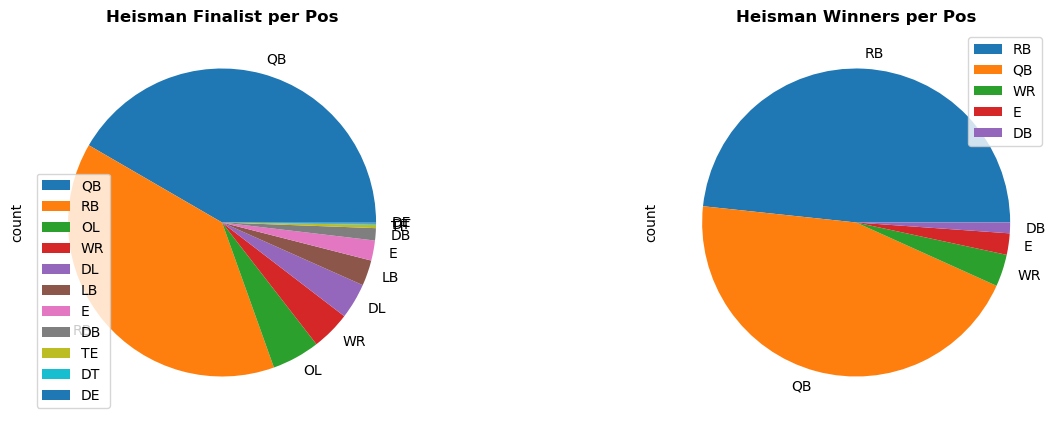

In [9]:
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
ballot_df.pos.value_counts().plot(kind = 'pie')
plt.legend()
plt.title('Heisman Finalist per Pos', fontweight = 'bold')

plt.subplot(1, 2, 2)
ballot_df.loc[ballot_df['finish']==1,'pos'].value_counts().plot(kind = 'pie')
plt.legend()
plt.title('Heisman Winners per Pos', fontweight = 'bold')

If you don't know much about football, both of the finalists and winners are offensive players. We can look at the proportion below.

/var/folders/98/4ytxw5ld3c52rrh0718j8q6w0000gp/T/ipykernel_7002/1071043904.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


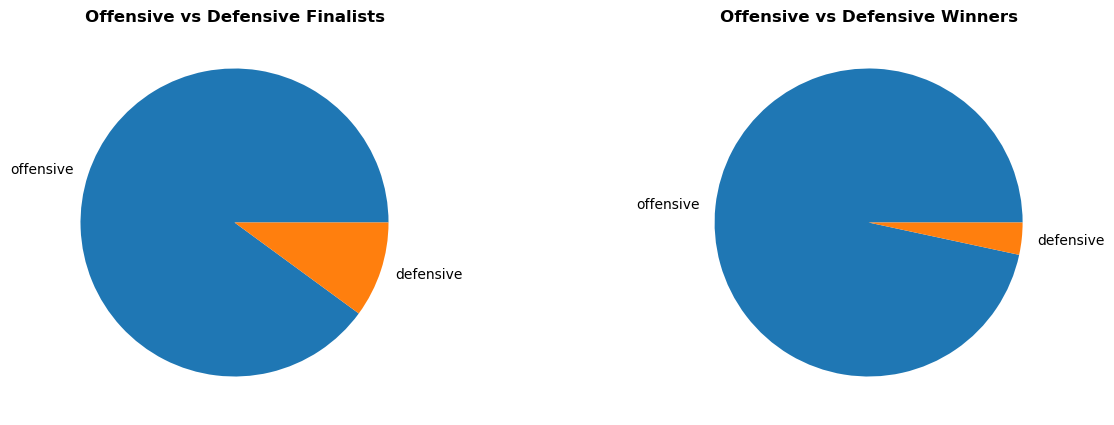

In [10]:
x1 = len(ballot_df.loc[ballot_df['pos'].isin(['QB', 'RB', 'OL', 'WR', 'TE'])==True])/len(ballot_df)
x2 = 1-x1
contend = [x1,x2] 
y1 = len(ballot_df.loc[(ballot_df['pos'].isin(['QB', 'RB', 'OL', 'WR', 'TE'])==True) & (ballot_df['finish']==1)])/len(ballot_df.loc[ballot_df['finish']==1])
y2 = 1 - y1
winners = [y1,y2]

plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.pie(contend, labels = ['offensive','defensive'])
plt.title('Offensive vs Defensive Finalists',fontweight = 'bold')
plt.subplot(1, 2, 2)
plt.pie(winners, labels = ['offensive','defensive'])
plt.title('Offensive vs Defensive Winners', fontweight = 'bold')
plt.show()

Given the small number of defensive stats, our main focus will be offensive players, so we will be scraping only offsive statistcs which includes passing, rushing, and receiving. We will be scraping sportsreference again for these. Our process remains the same.

In [11]:
#First, build the urls. One for passing, one for rushing, and one for urls
passing_urls = ['https://www.sports-reference.com/cfb/years/' + f"{year}" + '-passing.html' for year in range(1935,2024)]
rushing_urls = ['https://www.sports-reference.com/cfb/years/' + f"{year}" + '-rushing.html' for year in range(1935,2024)]
rec_urls = ['https://www.sports-reference.com/cfb/years/' + f"{year}" + '-receiving.html' for year in range(1935,2024)]

In [21]:
#functions used to build the dataframes
def fix_name(name):
    split = name.split("*")
    return split[0].strip()

def normalize_df_build(soup):
    table = soup.find_all('tbody')[0]
    rows = table.find_all('tr')
    col_names = [thing.get('data-stat') for thing in rows[0].find_all('td')]
    all_row_data = [[thing.text for thing in row.find_all('td')] for row in rows]
    row_data = [list_ for list_ in all_row_data if len(list_) == len(col_names)]

    df = pd.DataFrame(columns = col_names, data = row_data)
    cols_to_normal = df.columns[4:]
    
    #Fills missing numerical data with zero
    df[cols_to_normal] = df[cols_to_normal].replace('',0)
    #transfroms numerical data to the desired datatype
    df[cols_to_normal] = df[cols_to_normal].astype(float)
    #Since we want to normalize at the year level, I'm going to normalize here since it will be easier in the long
    #run 
    
    normal_names = ['normal_' + col for col in cols_to_normal]
    df[normal_names] = df[cols_to_normal].apply(zscore)
    
    web_head = soup.find_all('h1')[0].text.split()
    df['year'] = pd.to_numeric(web_head[0].strip())
    df['stat_type'] = web_head[-2]
    
    return df



def get_pos_df(req_list):
    soups = [BeautifulSoup(req.text, 'html.parser') for req in req_list]
    df = pd.concat([normalize_df_build(soup) for soup in soups])
    cols = df.columns[3:-1].to_list()
    
    #making the flag column to track if player's statistics include the bowl game
    df['bowl_flag'] = np.where(df['player'].str.contains('\*') == True,1,0)
    #getting rid of the asterirsk so that I can deal with the players names much more easily
    df.player = df['player'].apply(lambda x: fix_name(x))
    return df

In [14]:
pass_request_list = []

for url in passing_urls:
    req = requests.get(url)
    time.sleep(5)
    if req.status_code == 200:
        pass_request_list.append(req)
    else:
        print('Issue with', url)

Issue with https://www.sports-reference.com/cfb/years/1935-passing.html
Issue with https://www.sports-reference.com/cfb/years/1936-passing.html
Issue with https://www.sports-reference.com/cfb/years/1937-passing.html
Issue with https://www.sports-reference.com/cfb/years/1938-passing.html
Issue with https://www.sports-reference.com/cfb/years/1939-passing.html
Issue with https://www.sports-reference.com/cfb/years/1940-passing.html
Issue with https://www.sports-reference.com/cfb/years/1941-passing.html
Issue with https://www.sports-reference.com/cfb/years/1942-passing.html
Issue with https://www.sports-reference.com/cfb/years/1943-passing.html
Issue with https://www.sports-reference.com/cfb/years/1944-passing.html
Issue with https://www.sports-reference.com/cfb/years/1945-passing.html
Issue with https://www.sports-reference.com/cfb/years/1946-passing.html
Issue with https://www.sports-reference.com/cfb/years/1947-passing.html
Issue with https://www.sports-reference.com/cfb/years/1948-passi

In [15]:
rush_request_list = []

for url in rushing_urls:
    req = requests.get(url)
    time.sleep(5)
    if req.status_code == 200:
        rush_request_list.append(req)
#     else:
#         print('Issue with', url)

In [16]:
rec_request_list = []

for url in rec_urls:
    req = requests.get(url)
    time.sleep(5)
    if req.status_code == 200:
        rec_request_list.append(req)
#     else:
#         print('Issue with', url)

In [22]:
pass_df = get_pos_df(pass_request_list)
rush_df = get_pos_df(rush_request_list)
rec_df = get_pos_df(rec_request_list)

In [23]:
pos_df_list = [pass_df, rush_df, rec_df]

for df in pos_df_list:
    display(df.head())
    display(df.describe())
    display(df.info())

,player,school_name,conf_abbr,g,pass_cmp,pass_att,pass_cmp_pct,pass_yds,pass_yds_per_att,adj_pass_yds_per_att,...,normal_pass_td,normal_pass_int,normal_pass_rating,normal_rush_att,normal_rush_yds,normal_rush_yds_per_att,normal_rush_td,year,stat_type,bowl_flag
0,Bob Newman,Washington State,PCC,10,91.0,170.0,53.5,1240.0,7.3,6.1,...,-0.552345,-1.139583,1.072325,-0.236538,-0.852475,-1.018998,-0.408248,1956,Passing,0
1,John Brodie,Stanford,PCC,10,139.0,240.0,57.9,1633.0,6.8,5.2,...,2.025264,0.404368,1.002434,0.709614,-0.024638,-0.041089,-1.837117,1956,Passing,0
2,Bob Reinhart,San Jose State,Ind,10,90.0,172.0,52.3,1138.0,6.6,6.5,...,0.736460,-1.911558,1.100282,-0.473076,-0.932960,-1.191571,1.020621,1956,Passing,0
3,Guy Martin,Colgate,Ind,9,88.0,170.0,51.8,1100.0,6.5,3.6,...,0.092057,0.661693,0.023963,-0.630768,0.619235,0.821773,-0.408248,1956,Passing,0
4,Charlie Arnold,SMU,SWC,10,71.0,157.0,45.2,964.0,6.1,3.1,...,-0.552345,0.404368,-0.681935,1.261536,-1.070932,-0.903950,1.020621,1956,Passing,0


,pass_cmp,pass_att,pass_cmp_pct,pass_yds,pass_yds_per_att,adj_pass_yds_per_att,pass_td,pass_int,pass_rating,rush_att,...,normal_adj_pass_yds_per_att,normal_pass_td,normal_pass_int,normal_pass_rating,normal_rush_att,normal_rush_yds,normal_rush_yds_per_att,normal_rush_td,year,bowl_flag
count,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,5295.000000,...,5.295000e+03,5.295000e+03,5.295000e+03,5.295000e+03,5.295000e+03,5.295000e+03,5.295000e+03,5.295000e+03,5295.000000,5295.000000
mean,168.791124,294.849292,56.067894,2120.192068,7.094353,6.299566,14.455524,10.547686,123.515524,78.429273,...,1.462685e-16,-5.367651e-18,-8.554693e-18,1.543200e-17,-8.386954e-19,-1.073530e-17,-6.374085e-18,-5.703129e-18,1995.818886,0.236638
std,68.347261,95.743283,6.862979,838.738367,1.110330,1.883938,8.259890,4.211443,21.647255,40.276583,...,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,17.632832,0.425059
min,23.000000,49.000000,26.200000,328.000000,3.100000,-1.500000,0.000000,0.000000,0.000000,0.000000,...,-3.523662e+00,-2.339697e+00,-2.791472e+00,-4.607977e+00,-2.165466e+00,-2.467308e+00,-3.935339e+00,-1.837117e+00,1956.000000,0.000000
25%,114.000000,216.500000,51.300000,1457.000000,6.300000,5.100000,8.000000,7.000000,109.300000,48.000000,...,-6.949390e-01,-7.363242e-01,-7.286524e-01,-6.835276e-01,-7.458413e-01,-6.948365e-01,-6.772230e-01,-7.259867e-01,1982.000000,0.000000
50%,157.000000,283.000000,56.400000,1995.000000,7.100000,6.300000,13.000000,10.000000,123.500000,70.000000,...,-1.509345e-02,-1.588600e-01,-8.076637e-02,-2.463695e-02,-1.996354e-01,-2.325018e-01,7.459148e-02,-2.700855e-01,1998.000000,0.000000
75%,213.000000,359.000000,60.900000,2648.000000,7.800000,7.600000,19.000000,13.000000,137.800000,100.000000,...,6.609682e-01,6.033061e-01,6.678794e-01,6.436198e-01,5.621509e-01,4.879196e-01,7.261728e-01,4.736329e-01,2011.000000,0.000000
max,512.000000,719.000000,77.400000,5967.000000,11.900000,13.600000,62.000000,34.000000,208.000000,317.000000,...,3.739252e+00,5.374817e+00,4.257287e+00,3.656828e+00,5.100101e+00,6.175664e+00,3.106461e+00,5.990783e+00,2023.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 5295 entries, 0 to 108
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player                       5295 non-null   object 
 1   school_name                  5295 non-null   object 
 2   conf_abbr                    5295 non-null   object 
 3   g                            5295 non-null   object 
 4   pass_cmp                     5295 non-null   float64
 5   pass_att                     5295 non-null   float64
 6   pass_cmp_pct                 5295 non-null   float64
 7   pass_yds                     5295 non-null   float64
 8   pass_yds_per_att             5295 non-null   float64
 9   adj_pass_yds_per_att         5295 non-null   float64
 10  pass_td                      5295 non-null   float64
 11  pass_int                     5295 non-null   float64
 12  pass_rating                  5295 non-null   float64
 13  rush_att                

None

,player,school_name,conf_abbr,g,rush_att,rush_yds,rush_yds_per_att,rush_td,rec,rec_yds,...,normal_rec_yds,normal_rec_yds_per_rec,normal_rec_td,normal_scrim_att,normal_scrim_yds,normal_scrim_yds_per_att,normal_scrim_td,year,stat_type,bowl_flag
0,Tommy Lorino,Auburn,SEC,10,82.0,692.0,8.4,4.0,1.0,27.0,...,-0.395589,1.762342,-0.533134,-0.421520,1.189941,2.610441,0.238381,1956,Rushing,0
1,Clendon Thomas,Oklahoma,Big 7,10,104.0,817.0,7.9,13.0,12.0,241.0,...,2.355256,1.065100,4.084559,0.768676,2.804299,2.882336,4.586404,1956,Rushing,0
2,Ron Mills,West Texas A&M,BIAA,9,77.0,569.0,7.4,0.0,1.0,6.0,...,-0.665532,-0.359700,-0.533134,-0.601852,0.504196,1.726781,-1.099472,1956,Rushing,0
3,Tommy McDonald,Oklahoma,Big 7,10,119.0,853.0,7.2,12.0,12.0,282.0,...,2.882287,1.408668,4.084559,1.309674,3.170982,2.610441,4.251940,1956,Rushing,0
4,Ken Wineburg,TCU,SWC,10,83.0,598.0,7.2,6.0,11.0,138.0,...,1.031251,0.297123,0.621290,-0.024788,1.270897,1.998677,1.241771,1956,Rushing,0


,rush_att,rush_yds,rush_yds_per_att,rush_td,rec,rec_yds,rec_yds_per_rec,rec_td,scrim_att,scrim_yds,...,normal_rec,normal_rec_yds,normal_rec_yds_per_rec,normal_rec_td,normal_scrim_att,normal_scrim_yds,normal_scrim_yds_per_att,normal_scrim_td,year,bowl_flag
count,20081.000000,20081.000000,20081.000000,20081.000000,20081.000000,20081.000000,20081.000000,20081.000000,20081.000000,20081.000000,...,2.008100e+04,2.008100e+04,2.008100e+04,2.008100e+04,2.008100e+04,2.008100e+04,2.008100e+04,2.008100e+04,20081.000000,20081.000000
mean,126.102535,551.106967,4.183816,5.059758,9.162940,84.388925,7.348155,0.467258,135.265475,635.495892,...,-2.299949e-18,-8.845958e-19,1.070361e-17,8.845958e-19,1.733808e-17,6.369090e-18,4.033757e-17,1.769192e-19,1988.147353,0.159952
std,53.157261,340.143769,1.523918,4.085407,10.395263,101.882852,6.348481,0.902595,57.603561,389.720856,...,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,19.493897,0.366571
min,14.000000,-415.000000,-5.900000,0.000000,0.000000,-25.000000,-25.000000,0.000000,14.000000,-415.000000,...,-1.116633e+00,-1.170875e+00,-4.909283e+00,-6.667620e-01,-1.889236e+00,-3.072452e+00,-5.864153e+00,-1.746769e+00,1956.000000,0.000000
25%,86.000000,327.000000,3.600000,2.000000,1.000000,4.000000,2.000000,0.000000,92.000000,375.000000,...,-7.978707e-01,-7.407273e-01,-8.484067e-01,-5.516240e-01,-7.670015e-01,-6.664454e-01,-3.923511e-01,-7.476052e-01,1972.000000,0.000000
50%,111.000000,481.000000,4.300000,4.000000,6.000000,51.000000,7.400000,0.000000,119.000000,564.000000,...,-2.693921e-01,-3.131240e-01,1.368652e-02,-4.755898e-01,-2.582900e-01,-1.610705e-01,1.300256e-01,-1.936475e-01,1986.000000,0.000000
75%,152.000000,714.000000,5.100000,7.000000,14.000000,126.000000,10.500000,1.000000,164.000000,834.000000,...,4.819267e-01,4.148802e-01,5.254544e-01,4.382459e-01,5.266123e-01,5.569708e-01,5.896164e-01,5.044454e-01,2005.000000,0.000000
max,450.000000,2628.000000,10.100000,37.000000,99.000000,1099.000000,87.000000,9.000000,474.000000,2809.000000,...,9.164157e+00,8.002854e+00,1.072367e+01,1.104668e+01,5.320994e+00,5.548183e+00,4.783617e+00,7.483189e+00,2023.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 20081 entries, 0 to 287
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player                    20081 non-null  object 
 1   school_name               20081 non-null  object 
 2   conf_abbr                 20081 non-null  object 
 3   g                         20081 non-null  object 
 4   rush_att                  20081 non-null  float64
 5   rush_yds                  20081 non-null  float64
 6   rush_yds_per_att          20081 non-null  float64
 7   rush_td                   20081 non-null  float64
 8   rec                       20081 non-null  float64
 9   rec_yds                   20081 non-null  float64
 10  rec_yds_per_rec           20081 non-null  float64
 11  rec_td                    20081 non-null  float64
 12  scrim_att                 20081 non-null  float64
 13  scrim_yds                 20081 non-null  float64
 14  scrim_yds_per

None

,player,school_name,conf_abbr,g,rec,rec_yds,rec_yds_per_rec,rec_td,rush_att,rush_yds,...,normal_rush_yds,normal_rush_yds_per_att,normal_rush_td,normal_scrim_att,normal_scrim_yds,normal_scrim_yds_per_att,normal_scrim_td,year,stat_type,bowl_flag
0,Jim Morse,Notre Dame,Ind,10,20.0,442.0,22.1,1.0,68.0,148.0,...,0.439915,0.000730,-0.333994,1.446043,0.866410,-1.617568,-0.836599,1956,Receiving,0
1,Farrell Funston,Pacific,Ind,10,27.0,563.0,20.9,5.0,0.0,0.0,...,-0.472021,-0.609755,-0.333994,-0.397702,0.724453,2.229235,0.881820,1956,Receiving,0
2,Ernie Pitts,Denver,Skyline,10,21.0,415.0,19.8,6.0,1.0,7.0,...,-0.428889,1.332699,0.512124,-0.548828,-0.016880,1.768702,1.741030,1956,Receiving,0
3,Ron Kramer,Michigan,Big Ten,9,18.0,353.0,19.6,2.0,5.0,19.0,...,-0.354948,0.444720,-0.333994,-0.518603,-0.279764,0.955997,-0.406994,1956,Receiving,0
4,Fred Dugan,Dayton,Ind,10,26.0,481.0,18.5,4.0,1.0,15.0,...,-0.379595,3.552646,-0.333994,-0.397702,0.372188,1.551981,0.452216,1956,Receiving,0


,rec,rec_yds,rec_yds_per_rec,rec_td,rush_att,rush_yds,rush_yds_per_att,rush_td,scrim_att,scrim_yds,...,normal_rush_att,normal_rush_yds,normal_rush_yds_per_att,normal_rush_td,normal_scrim_att,normal_scrim_yds,normal_scrim_yds_per_att,normal_scrim_td,year,bowl_flag
count,19783.000000,19783.000000,19783.000000,19783.000000,19783.000000,19783.000000,19783.000000,19783.000000,19783.000000,19783.000000,...,1.978300e+04,1.978300e+04,1.978300e+04,1.978300e+04,1.978300e+04,1.978300e+04,1.978300e+04,1.978300e+04,19783.000000,19783.000000
mean,37.803468,504.087044,13.258004,3.487287,22.246120,108.984077,2.734742,0.958095,60.049588,613.071122,...,-7.183367e-19,2.873347e-18,-2.514178e-18,7.183367e-18,-2.155010e-18,1.526465e-17,2.155010e-17,-3.232515e-18,1997.761563,0.256331
std,16.103290,254.014713,3.483750,2.927221,55.917526,279.363937,5.175808,2.787382,56.108790,321.965506,...,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,17.520268,0.436618
min,4.000000,7.000000,1.400000,0.000000,0.000000,-129.000000,-40.000000,0.000000,4.000000,28.000000,...,-7.097887e-01,-1.028232e+00,-8.564650e+00,-5.495605e-01,-9.776160e-01,-1.748639e+00,-2.785228e+00,-1.648474e+00,1956.000000,0.000000
25%,26.000000,322.000000,10.900000,1.000000,0.000000,0.000000,0.000000,0.000000,30.000000,384.000000,...,-3.981937e-01,-4.007937e-01,-5.489123e-01,-3.618649e-01,-5.477611e-01,-7.217284e-01,-5.823330e-01,-7.116649e-01,1984.000000,0.000000
50%,33.000000,444.000000,13.100000,3.000000,1.000000,0.000000,0.000000,0.000000,40.000000,530.000000,...,-3.504717e-01,-3.526611e-01,-3.975356e-01,-3.314389e-01,-3.552375e-01,-2.579365e-01,6.114703e-02,-2.508547e-01,2001.000000,0.000000
75%,45.000000,627.000000,15.400000,5.000000,6.000000,36.500000,4.900000,0.000000,61.000000,754.000000,...,-2.721752e-01,-2.478916e-01,4.155544e-01,-2.833864e-01,1.908740e-02,4.685963e-01,6.518976e-01,4.626031e-01,2013.000000,1.000000
max,158.000000,2060.000000,31.900000,27.000000,403.000000,2342.000000,77.000000,28.000000,432.000000,2664.000000,...,6.679224e+00,8.376438e+00,1.159952e+01,9.699086e+00,6.716831e+00,6.563466e+00,5.290866e+00,7.376893e+00,2023.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 19783 entries, 0 to 473
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player                    19783 non-null  object 
 1   school_name               19783 non-null  object 
 2   conf_abbr                 19783 non-null  object 
 3   g                         19783 non-null  object 
 4   rec                       19783 non-null  float64
 5   rec_yds                   19783 non-null  float64
 6   rec_yds_per_rec           19783 non-null  float64
 7   rec_td                    19783 non-null  float64
 8   rush_att                  19783 non-null  float64
 9   rush_yds                  19783 non-null  float64
 10  rush_yds_per_att          19783 non-null  float64
 11  rush_td                   19783 non-null  float64
 12  scrim_att                 19783 non-null  float64
 13  scrim_yds                 19783 non-null  float64
 14  scrim_yds_per

None

Finally, the last thing that we need to scrape is the AP poll which we will scrape from wikipedia. Just as the others, we are scraping on the year level, and then concating the dataframes together. There are four different ways the ap poll is formed because of how divisions have shifted since the 30s.

In [24]:
#Making the urls
ap_urls1 = ['https://en.wikipedia.org/wiki/' + f'{year}' + '_NCAA_University_Division_football_rankings' for year in range(1960,1973)]
ap_urls2 = ['https://en.wikipedia.org/wiki/' + f'{year}' + '_NCAA_Division_I_football_rankings' for year in range(1973,1978)]
ap_urls3 = ['https://en.wikipedia.org/wiki/' + f'{year}' + '_NCAA_Division_I-A_football_rankings' for year in range(1978,2006)]
ap_urls4 = ['https://en.wikipedia.org/wiki/' + f'{year}' + '_NCAA_Division_I_FBS_football_rankings' for year in range(2006,2024)]

#combining all of the urls
ap_urls = ap_urls1 + ap_urls2 + ap_urls3 + ap_urls4

#getting the requests
ap_req = [requests.get(url) for url in ap_urls]

In [25]:
ap_soups = []
for req in ap_req:
    if req.status_code == 200:
        ap_soups.append(BeautifulSoup(req.text, 'html.parser'))
    else:
        print(ap_req.index(req))

In [26]:
def get_ap_poll(soup, year):
    rows = soup.find_all('table', class_ = 'wikitable')[0].find_all('tbody')[0].find_all('tr')
    all_row_data = [row.find_all('td') for row in rows[:-1]]
    text_data = [[thing.text.strip() for thing in row] for row in all_row_data]
    text_data = [list_ for list_ in text_data if len(list_)>1]
    col_names = ["week_" + f'{k}' for k in range(0,len(text_data[0]))]
    df = pd.DataFrame(columns = col_names, data = text_data)
    df['year'] = year
    return df

In [27]:
years = list(range(1960,2024))

ap_polls = pd.concat([get_ap_poll(ap_soups[k],years[k]) for k in range(0,len(ap_soups))])

ap_polls = ap_polls.reset_index()
ap_polls['rank'] = ap_polls['index'] + 1
ap_polls = ap_polls[['rank','week_0','week_1','week_2','week_3','week_4','week_5','week_6','week_7','week_8','week_9',
                    'week_10', 'week_11','week_12','week_13','week_14','week_15','week_16','week_17',
                     'year']]

ap_polls.tail()

,rank,week_0,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,year
1380,21,North Carolina,Duke (1–0),Duke (2–0),Washington State (3–0),Tennessee (3–1),Missouri (5–0),Notre Dame (5–2),Louisville (6–1),Tennessee (5–2),Tulane (7–1),James Madison (9–0),Tennessee (7–3),Oklahoma State (8–3),NC State (9–3) т,Oregon State (8–4),,NaN,NaN,2023
1381,22,Ole Miss,Colorado (1–0),Miami (FL) (2–0),UCLA (3–0),Florida (3–1),Tennessee (4–1),LSU (4–2),Air Force (6–0),Tulane (6–1),Kansas (6–2),Notre Dame (7–3),North Carolina (8–2),Liberty (11–0),Oregon State (8–4) т,Oklahoma State (9–4),,NaN,NaN,2023
1382,23,Texas A&M,Texas A&M (1–0),Washington State (2–0),Tennessee (2–1),Missouri (4–0),LSU (3–2),Kansas (5–1),Tulane (5–1),UCLA (5–2),James Madison (8–0),Arizona (6–3),Kansas State (7–3),Toledo (10–1),Toledo (11–1),Tulane (11–2),,NaN,NaN,2023
1383,24,Tulane,Tulane (1–0),UCLA (2–0),Iowa (3–0),Kansas (4–0),Fresno State (5–0),Kentucky (5–1),Iowa (6–1),USC (6–2),USC (7–2),North Carolina (7–2),Oklahoma State (7–3),James Madison (10–1),James Madison (11–1),James Madison (11–1),,NaN,NaN,2023
1384,25,Iowa,Clemson (0–1),Iowa (2–0),Florida (2–1),Fresno State (4–0),Louisville (5–0),Miami (FL) (4–1),UCLA (4–2),James Madison (7–0),Kansas State (6–2),Liberty (9–0),Liberty (10–0),Tennessee (7–4),SMU (10–2),Tennessee (8–4),,NaN,NaN,2023


In [28]:
ap_polls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   rank     1385 non-null   int64 
 1   week_0   1385 non-null   object
 2   week_1   1385 non-null   object
 3   week_2   1385 non-null   object
 4   week_3   1385 non-null   object
 5   week_4   1385 non-null   object
 6   week_5   1385 non-null   object
 7   week_6   1385 non-null   object
 8   week_7   1385 non-null   object
 9   week_8   1385 non-null   object
 10  week_9   1385 non-null   object
 11  week_10  1385 non-null   object
 12  week_11  1375 non-null   object
 13  week_12  1325 non-null   object
 14  week_13  1295 non-null   object
 15  week_14  1215 non-null   object
 16  week_15  1015 non-null   object
 17  week_16  465 non-null    object
 18  week_17  100 non-null    object
 19  year     1385 non-null   int64 
dtypes: int64(2), object(18)
memory usage: 216.5+ KB


In [29]:
fraction = ap_polls.iloc[232][15][-2]
fraction

'½'

In [30]:
def regex_make_rec(x):
    result = re.search(r'\([0-9]{1,2}.*[0-9]{1,2}\)',x)
    if result == None:
        return x
    else:
        return result.group()
def regex_cut_count(x):
    name = re.sub(r'\([0-9]{1,2}\)$','',x)
    return name.strip()
def regex_cut_rec(x):
    name = re.sub(r'\([0-9]{1,2}.*[0-9]{1,2}\)','',x)
    return name.strip()

def fix_frac(x):
    result = re.sub(r'\([0-9]{1,2}\s\)','',x)
    return result.strip()

ap_polls = ap_polls.fillna('NA')
hw = ap_polls.iloc[959][13].split()[0]

for col in ap_polls.columns[1:-1]:
    ap_polls[col] = ap_polls[col].apply(lambda x:re.sub(r'\*','', x))
    
    ap_polls[col] = ap_polls[col].str.replace(fraction,'')
    ap_polls[col] = ap_polls[col].apply(lambda x: fix_frac(x))
   
    
    #first we want to remove the number of votes a team recieved. In a perfect world with unlimited time, we would 
    #want to leverage this information, but we don't have that, so we are just going to remove it
    ap_polls[col] = ap_polls[col].apply(lambda x: regex_cut_count(x))
    
    #Now we want to make a new column with the record, and delete it from the name col
    new_col_name = col + '_school'
    new_col_record = col + '_record'
    ap_polls[f'{new_col_record}'] = ap_polls[col].apply(lambda x: regex_make_rec(x))
    ap_polls[f'{new_col_record}'] = ap_polls[f'{new_col_record}'].str.strip()
    
    ap_polls[f'{new_col_name}'] = ap_polls[col].apply(lambda x:regex_cut_rec(x))
    ap_polls[f'{new_col_name}'] =  ap_polls[f'{new_col_name}'].str.strip()
    
    ap_polls.loc[ap_polls[new_col_name] ==hw, new_col_name] = 'Hawaii'
    ap_polls.loc[ap_polls[new_col_name] == "Mississippi", new_col_name] = 'Ole Miss'
    ap_polls.loc[ap_polls[new_col_name] == "Miami", new_col_name] = 'Miami (FL)'
    ap_polls.loc[ap_polls[new_col_name] == "Pittsburgh", new_col_name] = 'Pitt'
    ap_polls.loc[ap_polls[new_col_name] == "NC State", new_col_name] = 'North Carolina State'
    ap_polls.loc[ap_polls[new_col_name] == "Southern Miss", new_col_name] = 'Southern Mississippi'
    ap_polls.loc[ap_polls[new_col_name] == "Bowling Green", new_col_name] = 'Bowling Green State'
    ap_polls.loc[ap_polls[new_col_name] == "BYU", new_col_name] = 'Brigham Young'

Now the AP use to allow for ties, so we are going to have to fix that. The tied teams will have a special charcter which I extract with the test and special_char lines. We end up returning a list of the teams that were tied.

In [31]:
test = ap_polls.loc[ap_polls['week_2'].str.contains('Bowling Green')==True,'week_2'].values[0]
special_char = test[-1]
def tie_splitter(entry):
    split = entry.split(special_char)
    if len(split) == 1:
        return entry
    elif len(split)==2:
        return split[0].strip()
    else:
        final_split = [value.strip() for value in split if len(value)> 0]
        return final_split

In [32]:
school_cols = ap_polls.columns[21::2]
for col in school_cols:
    ap_polls[col] = ap_polls[col].apply(lambda x: tie_splitter(x))

In [34]:
bad_dict = {'BYU':'Brigham Young', 'Mississippi': 'Ole Miss', 'NC State':'North Carolina State',  
            'Pittsburgh':'Pitt', 'Bowling Green': 'Bowling Green State','North Carolina  T':'North Carolina',
            'Auburn  T':'Auburn','Northwestern  T':'Northwestern','Colorado  T':'Colorado','Alabama  T':'Alabama',
            'Kansas State  T':'Kansas','Purdue  T': 'Purdue','Virginia Tech  T':'Virginia Tech'}
for thing in bad_dict.keys():
    for col in ap_polls.columns[2::2]:
        ap_polls.loc[ap_polls[col]==thing, col] = bad_dict[thing]

In [35]:
count_df_list = []
no_polls_per_year_dict = {}
no_polls = 0
no_weeks_dict = {}
top = []
for year in ap_polls.year.unique():
    filtered_df = ap_polls.loc[ap_polls['year']==year]
    no_na = filtered_df.apply(lambda x: x.str.contains("NA").sum(), axis=1).values[0]
    no_polls_per_year_dict[year] = 18-no_na
    no_polls = no_polls + (18 - no_na)
    no_weeks_dict[year] = no_polls
    top.append(len(filtered_df))
    count_dict = {}
    nested_schools = []
    
    #getting all of the schools
    for col in school_cols:
        nested_schools.append(filtered_df[col].values.tolist())
        
    #now we need to flatten the list so that we can count    
    flat_schools = [school for list_ in nested_schools for school in list_]
    all_schools = [thing for thing in flat_schools if thing != 'NA']
    
    #some of these could be ties, in which case they appear as a list. We need to add in an if statement for those.
    if all(type(val) == type(flat_schools[0]) for val in flat_schools) == False:
        #Now we are going to add our little step to deal with the futher nested guy..
        singletons = [school  for school in flat_schools if type(school) == str]
        still_nested = [school for school in flat_schools if type(school) == list]
        unnested_ties = [school for sublist in still_nested for school in sublist]
        
        all_schools = unnested_ties + singletons
        
    for school in all_schools:
        count_dict[school] = all_schools.count(school)
    new_dict = {}
    new_dict['school_name'] = count_dict.keys()
    new_dict['count'] = count_dict.values()
    df = pd.DataFrame.from_dict(new_dict)

    df['year'] = year
    count_df_list.append(df)
all_years_count_df = pd.concat(count_df_list)
all_years_count_df = all_years_count_df.loc[(all_years_count_df['school_name'] !='NA')&(all_years_count_df['school_name'] !='')]

In [36]:
all_years_count_df

,school_name,count,year
0,Syracuse,12,1960
1,Ole Miss,12,1960
2,Washington,12,1960
3,Texas,6,1960
4,Illinois,4,1960
...,...,...,...
40,Liberty,5,2023
41,Toledo,2,2023
42,NC State,1,2023
43,SMU,2,2023


In [37]:
urls = ['https://www.sports-reference.com/cfb/years/' + f'{year}' + '-standings.html' for year in range(1935,2024)]
record_soups = []
for url in urls:
    record_soups.append(BeautifulSoup(requests.get(url).text, 'html.parser'))
    time.sleep(5)

In [38]:
record_df = pd.concat([not_norm_df_build(soup) for soup in record_soups])
record_df.head()

,school_name,conf_abbr,wins,losses,ties,win_loss_pct,wins_conf,losses_conf,ties_conf,win_loss_pct_conf,points_per_g,opp_points_per_g,srs,sos,notes,year,rank_pre,rank_min,rank_final,rank_current
0,Nebraska,Big 6,6,2,1,.722,4,0,1,.900,15.3,7.9,13.25,5.91,,1935,NaN,NaN,NaN,NaN
1,Oklahoma,Big 6,6,3,0,.667,3,2,0,.600,11.0,4.9,7.83,1.27,,1935,NaN,NaN,NaN,NaN
2,Kansas,Big 6,4,4,1,.500,2,2,1,.500,11.3,13.1,3.15,4.93,,1935,NaN,NaN,NaN,NaN
3,Kansas State,Big 6,2,4,3,.389,1,2,2,.400,4.4,5.4,1.20,2.98,,1935,NaN,NaN,NaN,NaN
4,Missouri,Big 6,3,3,3,.500,0,2,3,.300,10.8,8.6,1.52,0.97,,1935,NaN,NaN,NaN,NaN


In [39]:
rename_dict = {'Brigham Young': 'BYU','TCU': 'Texas Christian',
                                      'Bowling Green State':'Bowling Green'}
for school in rename_dict.keys():
    all_years_count_df.loc[all_years_count_df['school_name']==school,'school_name'] = rename_dict[school]

In [40]:
merge_data = record_df.loc[record_df['year']>= 1960]
merged_df = pd.merge(left = merge_data, right = all_years_count_df, on = ['school_name', 'year'],how = 'left').fillna(0)
merged_df.head()

,school_name,conf_abbr,wins,losses,ties,win_loss_pct,wins_conf,losses_conf,ties_conf,win_loss_pct_conf,...,opp_points_per_g,srs,sos,notes,year,rank_pre,rank_min,rank_final,rank_current,count
0,Washington,AAWU,10,1,0,.909,4,0,0,1.000,...,9.7,14.37,1.46,,1960,3,3,6,0,12.0
1,USC,AAWU,4,6,0,.400,3,1,0,.750,...,15.2,2.64,7.94,,1960,6,6,,0,1.0
2,UCLA,AAWU,7,2,1,.750,2,2,0,.500,...,8.4,13.21,4.41,,1960,,8,,0,8.0
3,California,AAWU,2,7,1,.250,1,3,0,.250,...,19.5,-5.42,4.68,,1960,,,,0,0.0
4,Stanford,AAWU,0,10,0,.000,0,4,0,.000,...,25.4,-11.52,3.68,,1960,,,,0,0.0


In [41]:
merged_df['no_ap_polls'] = merged_df['year'].map(no_polls_per_year_dict)
merged_df['polled_perc'] = merged_df['count']/merged_df['no_ap_polls']
merged_df.head()

,school_name,conf_abbr,wins,losses,ties,win_loss_pct,wins_conf,losses_conf,ties_conf,win_loss_pct_conf,...,sos,notes,year,rank_pre,rank_min,rank_final,rank_current,count,no_ap_polls,polled_perc
0,Washington,AAWU,10,1,0,.909,4,0,0,1.000,...,1.46,,1960,3,3,6,0,12.0,0,inf
1,USC,AAWU,4,6,0,.400,3,1,0,.750,...,7.94,,1960,6,6,,0,1.0,0,inf
2,UCLA,AAWU,7,2,1,.750,2,2,0,.500,...,4.41,,1960,,8,,0,8.0,0,inf
3,California,AAWU,2,7,1,.250,1,3,0,.250,...,4.68,,1960,,,,0,0.0,0,NaN
4,Stanford,AAWU,0,10,0,.000,0,4,0,.000,...,3.68,,1960,,,,0,0.0,0,NaN


In [42]:
rolling_dict = {}
window = 10
for school in merged_df.school_name.unique():
    filtered_df = merged_df.loc[merged_df['school_name']==school].copy()
    rolling_dict[school] = filtered_df['polled_perc'].rolling(window).mean().tolist()
    
    
merged_df['rolling_polled_perc'] = ''
for school in merged_df.school_name.unique():
    merged_df.loc[merged_df['school_name']== school,'rolling_polled_perc'] = rolling_dict[school]

In [43]:
merged_df.tail()

,school_name,conf_abbr,wins,losses,ties,win_loss_pct,wins_conf,losses_conf,ties_conf,win_loss_pct_conf,...,notes,year,rank_pre,rank_min,rank_final,rank_current,count,no_ap_polls,polled_perc,rolling_polled_perc
7716,Arkansas State,Sun Belt (West),6,6,0,.500,4,4,0,.500,...,,2023,,,0,,0.0,12,0.0,0.0
7717,South Alabama,Sun Belt (West),6,6,0,.500,4,4,0,.500,...,,2023,,,0,,0.0,12,0.0,0.0
7718,Louisiana,Sun Belt (West),6,6,0,.500,3,5,0,.375,...,,2023,,,0,,0.0,12,0.0,0.133333
7719,Southern Mississippi,Sun Belt (West),3,9,0,.250,2,6,0,.250,...,,2023,,,0,,0.0,12,0.0,0.0
7720,Louisiana-Monroe,Sun Belt (West),2,10,0,.167,0,8,0,.000,...,,2023,,,0,,0.0,12,0.0,0.0


In [44]:
merge_data_r = merged_df[['school_name','year', 'conf_abbr','wins','win_loss_pct','rank_final', 'count', 'no_ap_polls',
                       'polled_perc', 'rolling_polled_perc']]

merge_data_l1 = pass_df[['player', 'school_name', 'g','normal_pass_yds', 'normal_pass_yds_per_att',
                         'normal_pass_td','normal_rush_yds','normal_rush_yds_per_att', 'normal_rush_td', 
                         'year']].copy()

l1_rename_dict = {'normal_pass_yds':'off_cat1_yds','normal_pass_yds_per_att':'off_cat1_yds_per_att',
                  'normal_pass_td':'off_cat1_td','normal_rush_yds':'off_cat2_yds',
                  'normal_rush_yds_per_att':'off_cat2_yds_per_att', 'normal_rush_td': 'off_cat2_td'}

merge_data_l1.rename(columns = l1_rename_dict,inplace = True)
merge_data_l1['pos'] = 'QB'

merge_data_l2 = rush_df[['player', 'school_name','g','normal_rush_yds', 'normal_rush_yds_per_att',
                         'normal_rush_td','normal_rec_yds','normal_rec_yds_per_rec', 'normal_rec_td', 
                         'year']].copy()

l2_rename_dict = {'normal_rush_yds':'off_cat1_yds','normal_rush_yds_per_att':'off_cat1_yds_per_att',
                  'normal_rush_td':'off_cat1_td','normal_rec_yds':'off_cat2_yds',
                  'normal_rec_yds_per_att':'off_cat2_yds_per_att', 'normal_rec_td': 'off_cat2_td'}

merge_data_l2.rename(columns = l2_rename_dict,inplace = True)
merge_data_l2['pos'] = 'RB'

merge_data_l3 = rec_df[['player', 'school_name','g','normal_rec_yds', 'normal_rec_yds_per_rec',
                        'normal_rec_td','normal_rush_yds','normal_rush_yds_per_att', 'normal_rush_td', 
                        'year']].copy()

l3_rename_dict = {'normal_rec_yds':'off_cat1_yds','normal_rec_yds_per_att':'off_cat1_yds_per_att',
                  'normal_rec_td':'off_cat1_td','normal_rush_yds':'off_cat2_yds',
                  'normal_rush_yds_per_att':'off_cat2_yds_per_att', 'normal_rush_td': 'off_cat2_td'}

merge_data_l3.rename(columns = l3_rename_dict,inplace = True)
merge_data_l3['pos'] = 'WR/TE'
merge_data_l = pd.concat([merge_data_l1,merge_data_l2,merge_data_l3])

In [45]:
big_merge = pd.merge(left = merge_data_l, right = merge_data_r, on = ['school_name','year'], how = 'outer', validate = 'many_to_many')

In [46]:
big_merge.head()

,player,school_name,g,off_cat1_yds,off_cat1_yds_per_att,off_cat1_td,off_cat2_yds,off_cat2_yds_per_att,off_cat2_td,year,pos,normal_rec_yds_per_rec,conf_abbr,wins,win_loss_pct,rank_final,count,no_ap_polls,polled_perc,rolling_polled_perc
0,Bob Newman,Washington State,10,0.493975,1.543065,-0.552345,-0.852475,-1.018998,-0.408248,1956,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Chuck Morrell,Washington State,10,0.654697,-0.048028,0.064665,0.247132,NaN,-0.533134,1956,RB,-0.258650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Eddie Stevens,Washington State,10,-0.288194,-0.834202,0.064665,0.144297,NaN,-0.533134,1956,RB,0.428487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Don Ellingsen,Washington State,10,1.058117,NaN,-0.841399,-0.367272,0.056229,-0.333994,1956,WR/TE,0.755389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bill Steiger,Washington State,10,2.569788,NaN,1.326273,0.082535,2.165179,0.512124,1956,WR/TE,0.346668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
missing_players = set(ballot_df.player.unique()) - set(big_merge.player.unique())
missing_players

{'A.J. Hawk',
 'Ace Parker',
 'Aidan Hutchinson',
 'Alan Ameche',
 'Alex Karras',
 'Alex Wojciechowicz',
 'Angelo Bertelli',
 'Arnie Tucker',
 'Arnold Galiffa',
 'Babe Parilli',
 'Bernie Faloney',
 'Bill Austin',
 'Bill Burrell',
 'Bill Daley',
 'Bill Dudley',
 'Bill Fralic',
 'Bill Hillenbrand',
 'Bill Mccoll',
 'Bill Swiacki',
 'Billy Vessels',
 'Bob Bell',
 'Bob Chappuis',
 'Bob Fenimore',
 'Bob Garrett',
 'Bob Harrison',
 'Bob Jenkins',
 'Bob Macleod',
 'Bob Mcnamara',
 'Bob Odell',
 'Bob Pellegrini',
 'Bob Reynolds',
 'Bob Westfall',
 'Bob Williams',
 'Bobby Layne',
 'Brian Bosworth',
 'Bryant McKinnie',
 'Buddy Young',
 'Burr Baldwin',
 'Byron White',
 'Charles Woodson',
 'Charley Trippi',
 'Charlie Conerly',
 'Charlie Justice',
 'Chase Young',
 'Chris Long',
 'Chris Spielman',
 'Chuck Bednarik',
 'Cliff Tonnemaker',
 'Clint Castleberry',
 'Clint Frank',
 'Cornelius Bennett',
 'Creighton Miller',
 'Dan Currie',
 'Dan Foldberg',
 'Danny LaRose',
 'Dave Schreiner',
 "Davey O'Brien"

In [48]:
find1 = ballot_df.loc[(ballot_df['player'].isin(missing_players))&(ballot_df['year']>=1960)]
find1.loc[find1['pos'].isin(set(['QB', 'RB', "WR"]))==True]

,finish,player,school_name,class,pos,votes_first,votes_second,votes_third,points_won,summary,year,bowl_flag
417,7,Neil Lomax,Portland State,SR,QB,10,11,17,69,,1980,0
460,9,Jerry Rice,Mississippi Valley State,SR,WR,3,9,9,36,,1984,0
470,9,Joe Dudek,Plymouth State,SR,RB,12,4,12,56,,1985,0
477,5,Gordon Lockbaum,Holy Cross,JR,RB,32,39,68,242,,1986,0
485,3,Gordon Lockbaum,Holy Cross,SR,RB,108,103,127,657,,1987,0
556,3,Steve Mcnair,Alcorn State,SR,QB,111,85,152,655,,1994,0
723,10,Owen Marecic,Stanford,SR,RB,3,1,5,16,"23 Att, 46 Yds, 2.0 Avg, 5 TD",2010,1


The most of the players that we are missing are players that are from group of five teams, with the single exception being Owen Marecic at Stanford. Since none of them won, I will be leaving them out of my analysis.

# Step 2: Visualization

We already seen finalists and winners per position group, so let's see how they are distributed over time.

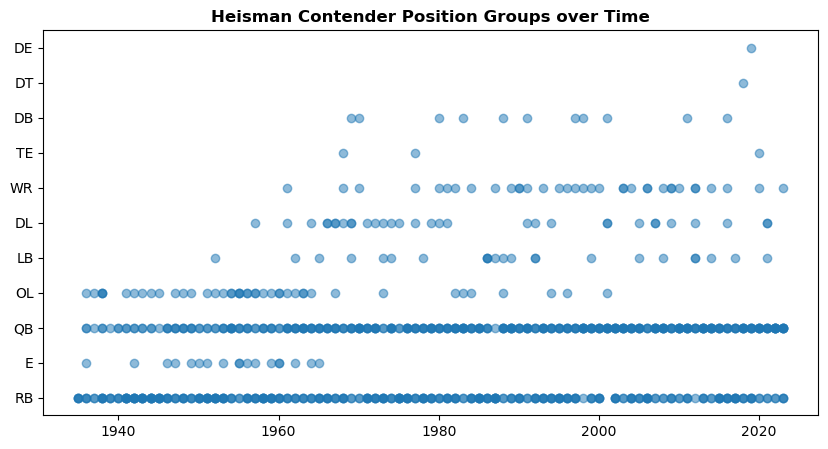

In [49]:
plt.figure(figsize=(10,5))
plt.scatter(ballot_df['year'],ballot_df['pos'], alpha = 0.5)
plt.title('Heisman Contender Position Groups over Time',fontweight = 'bold')
plt.show()

It looks like Quarterbacks have always been popular, but they did become slightly more so around the 60s and moving forwards. Running Backs, too, have been extremely popular, which matches what we found earlier.

Now let's look at the cummulative sum of the number of times the teams have appeared in the AP poll over time. Have teams always been consistently ranked? Are there any plateus where a team has had a down year?

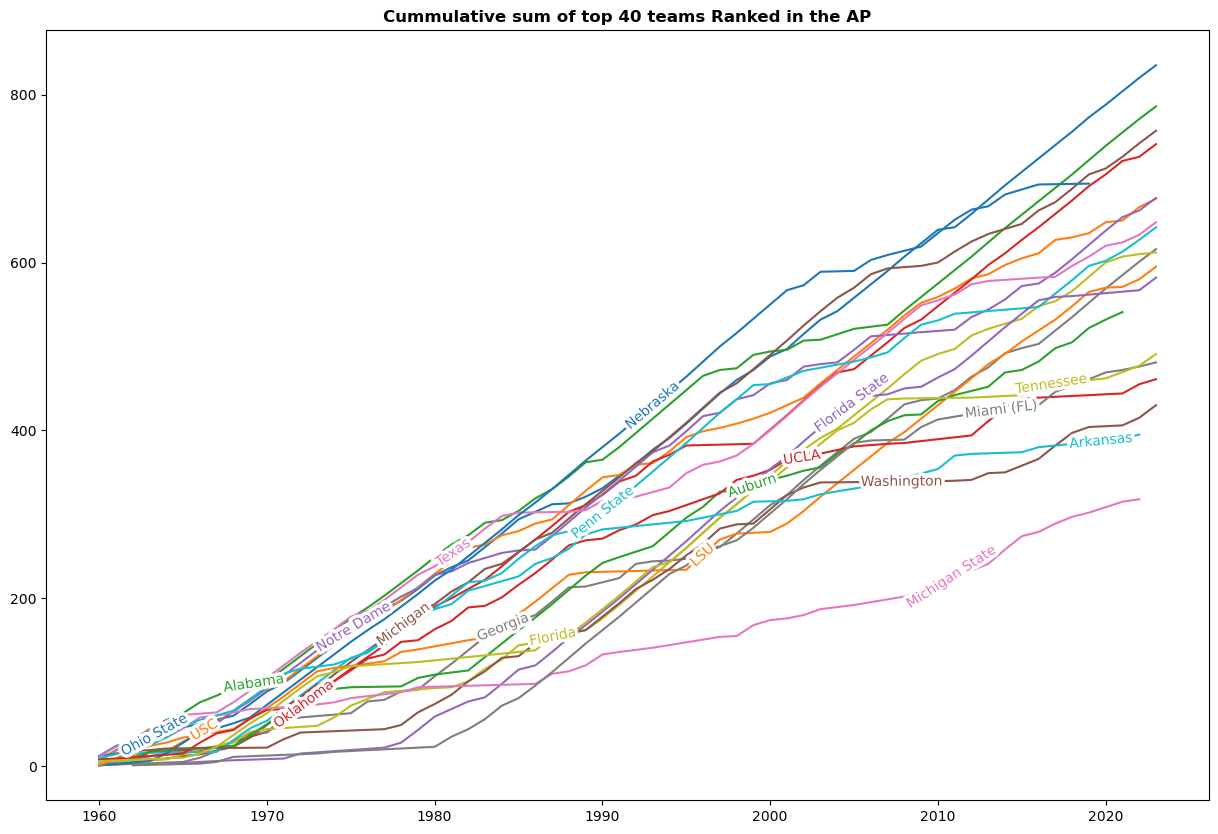

In [53]:
top_40_schools = all_years_count_df.school_name.value_counts().nlargest(20).index

plt.figure(figsize=(15,10))
for school in top_40_schools:
    filtered_df = all_years_count_df.loc[all_years_count_df['school_name']==school].copy()

    filtered_df['cumsum_per_team'] = filtered_df['count'].cumsum().values
    plt.plot(filtered_df['year'], filtered_df['cumsum_per_team'],label = school)
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.title('Cummulative sum of top 40 teams Ranked in the AP', fontweight = 'bold')
plt.show()

We can see some times Like Michigan State, Tennessee, Arkansas, Washington have all had some plateaus. Michigcan more so in the 80s and 90s. Meanwhile, teams like Nebraska, Oklahoma, Alabama, Florida State have all been pretty consistently ranked. It actually does seem that many of the top teams stay the top teams. 

Let's look at the top ten so we can gain more clarity about regarding the top teams that are consistently good.

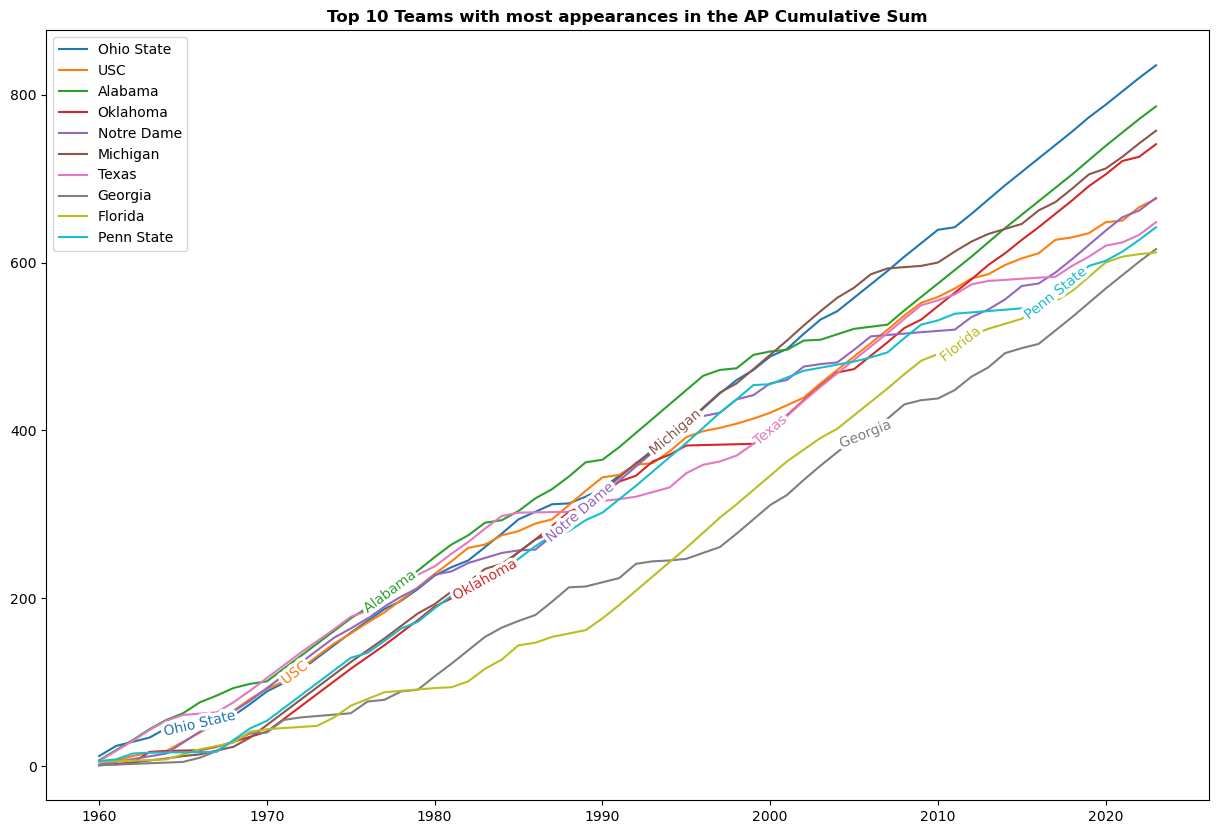

In [56]:
top_10_schools = all_years_count_df.school_name.value_counts().nlargest(10).index

plt.figure(figsize=(15,10))
for school in top_10_schools:
    filtered_df = all_years_count_df.loc[all_years_count_df['school_name']==school].copy()

    filtered_df['cumsum_per_team'] = filtered_df['count'].cumsum().values
    plt.plot(filtered_df['year'], filtered_df['cumsum_per_team'],label = school)
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.legend()
plt.title('Top 10 Teams with most appearances in the AP Cumulative Sum', fontweight = 'bold')
plt.show()

For the most part, after the 80s, the teams that have been consistently ranked since 1960 remain consistently ranked. This is important because the average person is more likely to know about a team if they are consistently good than teams that are flashes in the pan.

Now let's see who gets the most finalists and and gets the most winners.

/var/folders/98/4ytxw5ld3c52rrh0718j8q6w0000gp/T/ipykernel_7002/3980237925.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


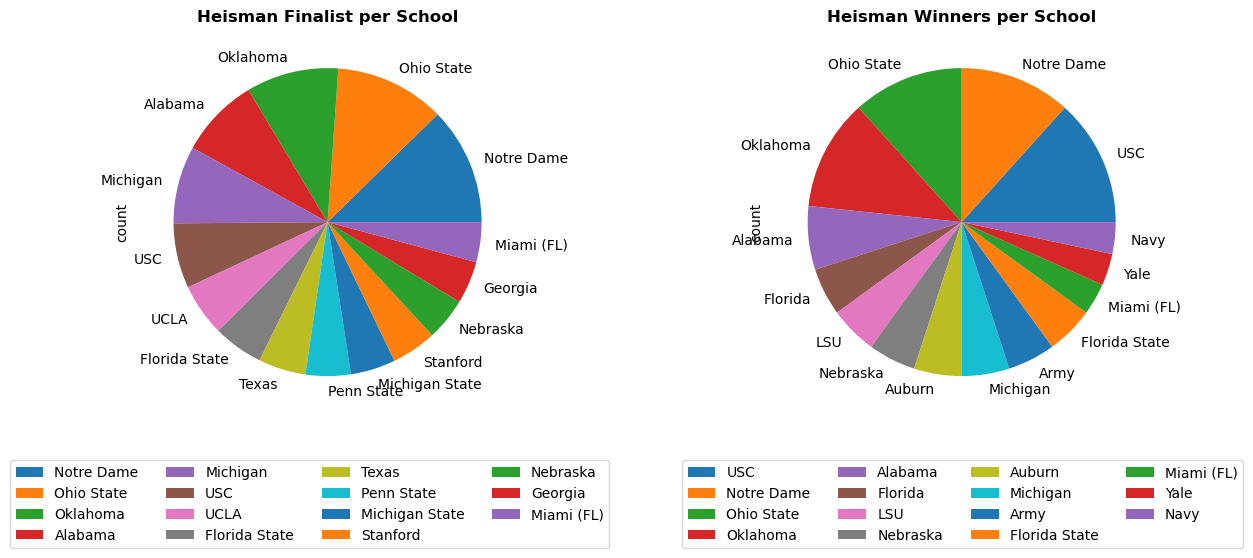

In [76]:
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
ballot_df.school_name.value_counts().nlargest(15).plot(kind = 'pie')
plt.legend(bbox_to_anchor=(1.25, -0.1), ncol=4)
plt.title('Heisman Finalist per School', fontweight = 'bold')


plt.subplot(1, 2, 2)
ballot_df.loc[ballot_df['finish']==1,'school_name'].value_counts().nlargest(15).plot(kind = 'pie')
plt.legend(bbox_to_anchor=(1.25, -0.1),ncol = 4)

plt.title('Heisman Winners per School', fontweight = 'bold')
plt.show()

Many of these seems to make sense ie they make up about the same proportion in both categories. USC however is one team that seems to when when they are nomoniated. UCLA does vanish completely, as does Standford. It should be noted that this does not mean that they didn't have in winners, but their number of winners is not in the top 10. It appears that Yale and Army have takens thier palces. Let's make a stacked bar so that we can see things a bit clearer.

This cell grabs the 15 schools with the most winners, and how many winners those schools have had. 

In [95]:
top_15_w = ballot_df.loc[ballot_df['finish']==1,'school_name'].value_counts().nlargest(15).index
top_15_w_counts =  ballot_df.loc[ballot_df['finish']==1,'school_name'].value_counts().nlargest(15).values

This next cell calculates schools with top 15 finalists but not top 15 in winners.

In [97]:
top_15_b = ballot_df.school_name.value_counts().nlargest(15).index
list(set(top_15_b)-(set(top_15_w)))

['UCLA', 'Georgia', 'Texas', 'Michigan State', 'Penn State', 'Stanford']

And the intersection..

In [98]:
intersect = list(set(top_15_w).intersection(set(top_15_b)))
intersect

['Notre Dame',
 'Nebraska',
 'Michigan',
 'Ohio State',
 'Miami (FL)',
 'Florida State',
 'USC',
 'Alabama',
 'Oklahoma']

In [103]:
b_count = []
w_count = []
select_schools = list(set(list(top_15_w) + list(top_15_b)))
for school in select_schools:
    b_count.append(len(ballot_df.loc[ballot_df['school_name']== school]))
    w_count.append(len(ballot_df.loc[(ballot_df['school_name']== school)&(ballot_df['finish']==1)]))

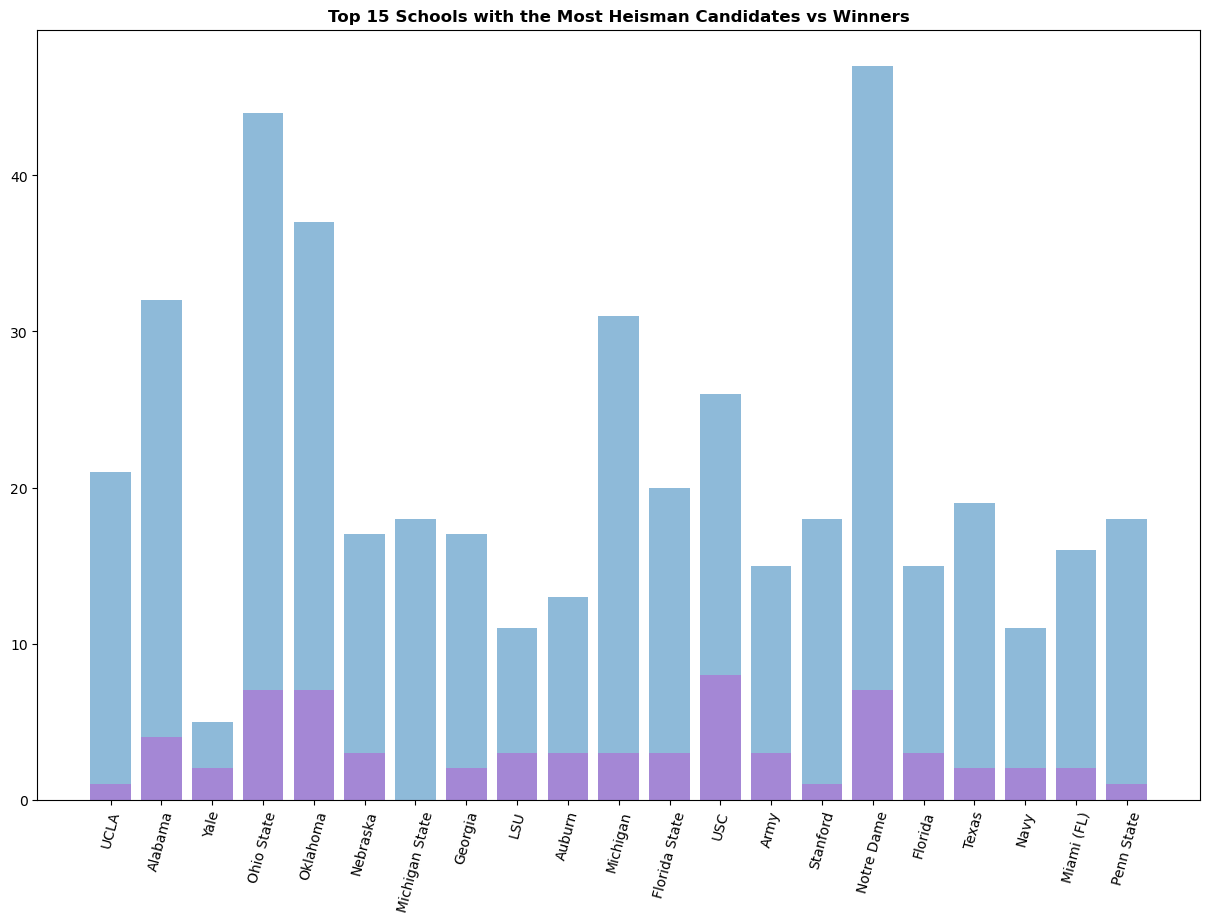

In [104]:
plt.figure(figsize=(15,10))
plt.bar(select_schools, b_count, alpha = 0.5)
plt.bar(select_schools, w_count,alpha = 0.5,color = 'mediumorchid')
plt.xticks(rotation = 75)
plt.title('Top 15 Schools with the Most Heisman Candidates vs Winners', fontweight = 'bold')
plt.show()

Now we can see that Michigan State has not had any winners, and USC seems to win more often when nominated compated to places like Ohio State, Oklahoma, and Notre Dame since the latter 3 have more finalists, but all four of those schools have about the same number of winners.

Now we want to know whether or not the finalists were true outliers in their position. Since the data is already normalized, we can do that by seeing whether or not they are more than 3 standard deviations away from the mean since we have a large sample size in each year.

In [167]:
#Here we are making a flag column for the heisman contenders.
subballot = ballot_df.loc[(ballot_df['pos'].isin(set(['QB','RB','WR','TE'])))&(ballot_df['year']>=1960)]
ballot = subballot[['player','year']]

big_merge['ballot_flag'] = 0
for yr in big_merge.year.unique():
    contend = set(ballot.loc[ballot['year']==yr,'player'].values)
    big_merge.loc[(big_merge['year']==yr)&(big_merge['player'].isin(contend)), 'ballot_flag'] = 1

In [169]:
cols_to_check = ['off_cat1_yds', 'off_cat1_yds_per_att','off_cat1_td', 'off_cat2_yds', 'off_cat2_yds_per_att', 
                 'off_cat2_td']

for col in cols_to_check:
    col_name = col + '_out_flag'
    big_merge[col_name] = np.where(big_merge[col]>=3,1,0)

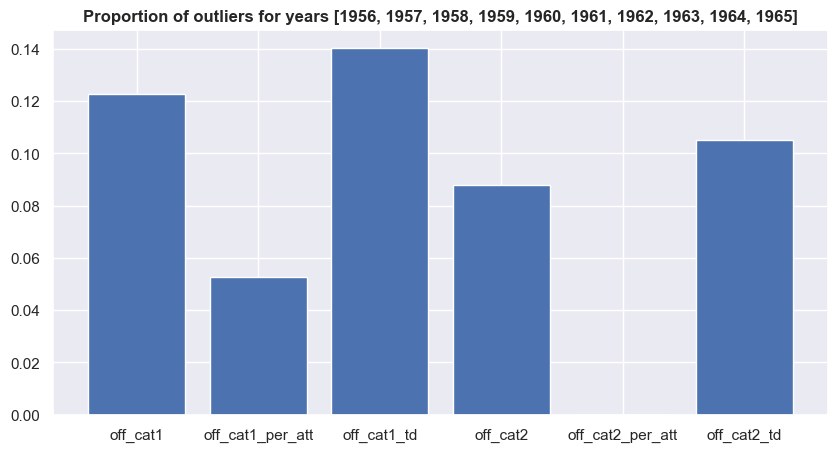

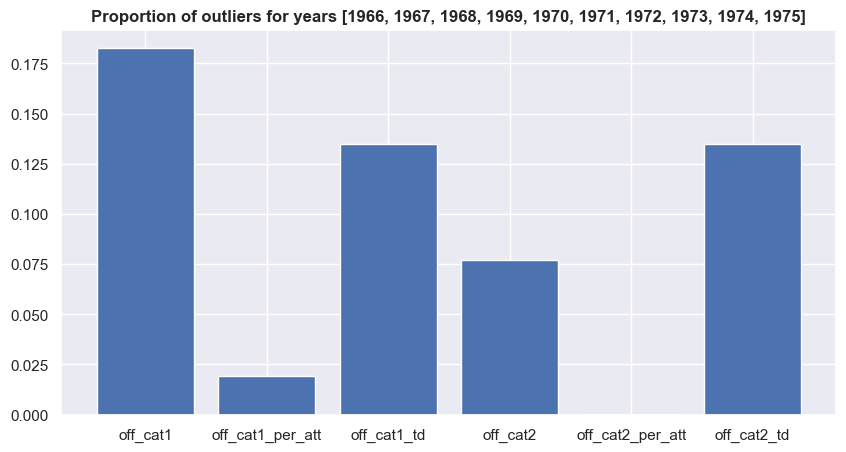

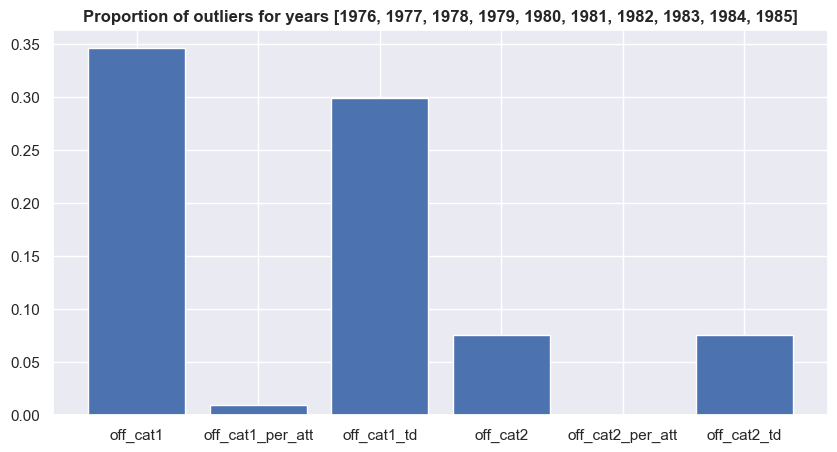

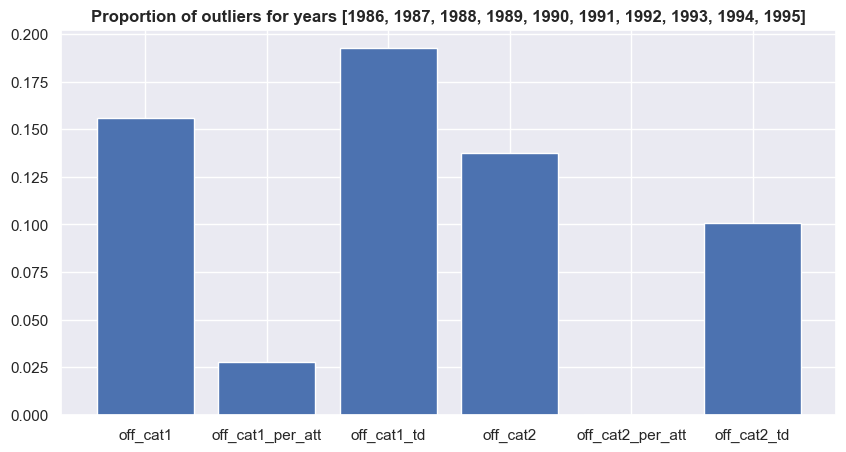

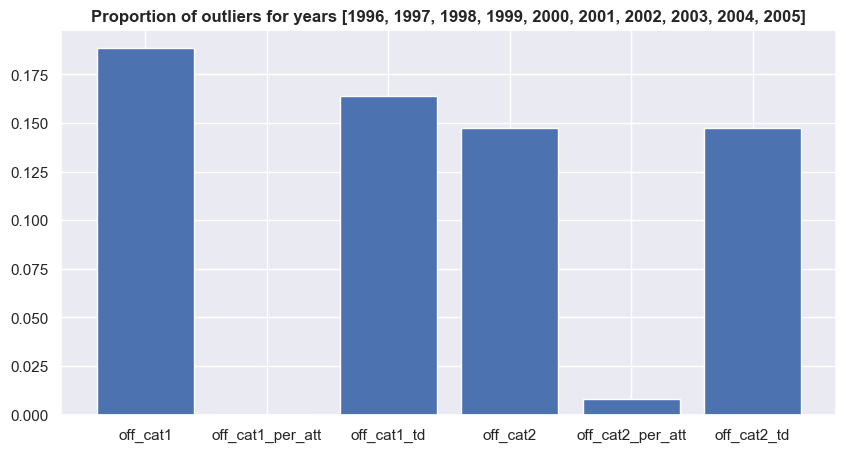

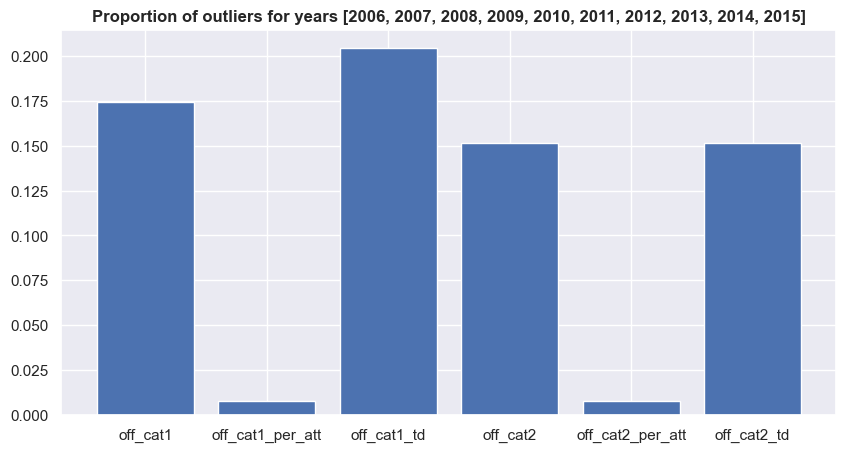

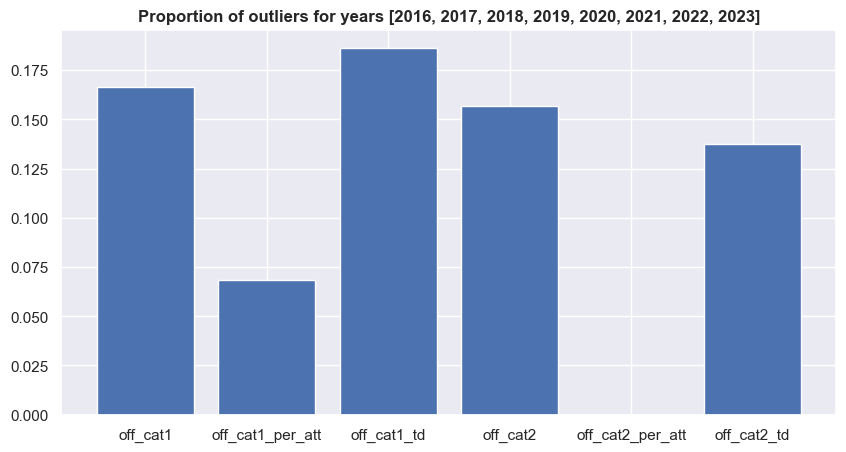

In [198]:
K = m.ceil(len(big_merge['year'].unique())/10)
for k in range(0,K):
    years = big_merge['year'].unique().tolist()[k*10:k*10+10]
    filtered_df = big_merge.loc[(big_merge['year'].isin(set(years)))&(big_merge['ballot_flag']==1)]
    off_cat1 = filtered_df['off_cat1_yds_out_flag'].sum()/len(filtered_df)
    off_cat1_per_att = filtered_df['off_cat1_yds_per_att_out_flag'].sum()/len(filtered_df)
    off_cat1_td = filtered_df['off_cat1_td_out_flag'].sum()/len(filtered_df)
    off_cat2 = filtered_df['off_cat2_yds_out_flag'].sum()/len(filtered_df)
    off_cat2_per_att = filtered_df['off_cat2_yds_per_att_out_flag'].sum()/len(filtered_df)
    off_cat2_td = filtered_df['off_cat2_td_out_flag'].sum()/len(filtered_df)
    plt.bar(list(range(0,6)),[off_cat1, off_cat1_per_att,off_cat1_td,off_cat2, off_cat2_per_att,off_cat2_td])
    plt.xticks(list(range(0,6)),['off_cat1', 'off_cat1_per_att','off_cat1_td','off_cat2', 'off_cat2_per_att','off_cat2_td'])
    plt.title('Proportion of outliers for years '+ f'{years}', fontweight = 'bold')
    plt.show()